## The Moving Average Model

## Importing Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
sns.set()

## Loading the Data

In [2]:
raw_csv_data = pd.read_csv('Index2018.csv')
raw_csv_data

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.900000,2224.95,3445.980000,18124.01
1,10/01/1994,475.270000,2225.00,3440.580000,18443.44
2,11/01/1994,474.130000,2228.10,3413.770000,18485.25
3,12/01/1994,474.170000,2182.06,3372.020000,18793.88
4,13/01/1994,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...,...
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88


In [3]:
df_comp = raw_csv_data.copy()

## Preprocessing the Data

In [4]:
df_comp.date = pd.to_datetime(df_comp.date, dayfirst= True)
df_comp.set_index('date', inplace = True)
df_comp = df_comp.drop(['spx', 'dax', 'nikkei'], axis = 1)
df_comp

,ftse
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


In [5]:
df_comp['market_value'] = df_comp.ftse
del df_comp['ftse']

In [6]:
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')
df_comp

,market_value
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


## Splitting the Data

In [7]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [8]:
df.tail()

,market_value
date,
2013-04-01,6411.74
2013-04-02,6490.66
2013-04-03,6420.28
2013-04-04,6344.11
2013-04-05,6249.77


In [9]:
df_test.head()

,market_value
date,
2013-04-08,6276.94
2013-04-09,6313.20
2013-04-10,6387.37
2013-04-11,6416.14
2013-04-12,6384.39


## LLR Test Function

In [10]:
from scipy.stats.distributions import chi2

In [11]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

## Augmented Dickey-Fuller Test

In [12]:
import statsmodels.tsa.stattools as sts

In [13]:
sts.adfuller(df.market_value)

(-1.9041551418836873,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

### From the DF test we see that the market value prices for FTSE100 belong to a Non-Stationery Source, hence it is a better option to Extract the "Returns", check for stationarity and then work on them

## Computing and Storing Returns

In [14]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## ACF of Returns (Since The MA model depends on the ACF(Autocorrelation Function) to determine it's number of Lags)

In [15]:
import statsmodels.graphics.tsaplots as sgt

[]

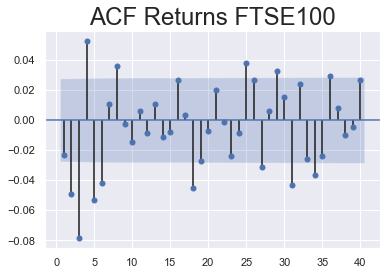

In [16]:
sgt.plot_acf(df.returns[1:], lags = 40, zero = False)
plt.title("ACF Returns FTSE100", size = 24)
plt.plot()

### From the above ACF plot we can determine that we require about 8 lags in our Moving Average(MA) model

## Building a "Simple" MA(1) Model

In [17]:
from statsmodels.tsa.arima_model import ARMA

In [18]:
model_ma_1  = ARMA(df.returns[1:], order = (0,1))
results_ma_1 = model_ma_1.fit()
results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 1)   Log Likelihood               -7929.595
Method:                       css-mle   S.D. of innovations              1.174
Date:                Thu, 23 Apr 2020   AIC                          15865.190
Time:                        23:56:49   BIC                          15884.754
Sample:                    01-10-1994   HQIC                         15872.045
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.162      0.245      -0.013       0.050
ma.L1.returns    -0.0257      0.015     -1.720      0.085      -0.055       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.8547           +0.0000j           38.8547            0.0000
-----------------------------------------------------------------------------
"""

## Moving Average Model With Higher Lags

In [19]:
model_ma_6 = ARMA(df.returns[1:], order = (0,6))
results_ma_6 = model_ma_6.fit()
results_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 6)   Log Likelihood               -7889.221
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 23 Apr 2020   AIC                          15794.442
Time:                        23:56:50   BIC                          15846.612
Sample:                    01-10-1994   HQIC                         15812.723
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.430      0.153      -0.007       0.045
ma.L1.returns    -0.0237      0.014     -1.682      0.093      -0.051       0.004
ma.L2.returns    -0.0486      0.014     -3.436      0.001      -0.076      -0.021
ma.L3.returns    -0.0827      0.014     -5.846      0.000      -0.110      -0.055
ma.L4.returns     0.0466      0.014      3.434      0.001       0.020       0.073
ma.L5.returns    -0.0484      0.014     -3.371      0.001      -0.077      -0.020
ma.L6.returns    -0.0387      0.014     -2.682      0.007      -0.067      -0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.5011           -0.0000j            1.5011           -0.0000
MA.2            0.8248           -1.4775j            1.6921           -0.1690
MA.3            0.8248           +1.4775j            1.6921            0.1690
MA.4           -1.0066           -1.2260j            1.5863           -0.3594
MA.5           -1.0066           +1.2260j            1.5863            0.3594
MA.6           -2.3891           -0.0000j            2.3891           -0.5000
-----------------------------------------------------------------------------
"""

In [20]:
model_ma_7 = ARMA(df.returns[1:], order = (0,7))
results_ma_7 = model_ma_7.fit()
print(results_ma_7.summary())
print("LLR Test p-value : " + str(LLR_test(model_ma_6,model_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 7)   Log Likelihood               -7889.046
Method:                       css-mle   S.D. of innovations              1.165
Date:                Thu, 23 Apr 2020   AIC                          15796.091
Time:                        23:56:53   BIC                          15854.782
Sample:                    01-10-1994   HQIC                         15816.657
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.418      0.156      -0.007       0.045
ma.L1.returns    -0.0247      0.014     -1.739      0.082      -0.052       0.003
ma.L2.returns    -0.0488      0.014     

### From the above Output we see that the value for the 7th lag is insignificant, although the ACF graph shoes that the 8th lag has a significant value, hence we test for the 8th lag and compare model_ma_6 with model_ma_8

In [21]:
model_ma_8 = ARMA(df.returns[1:], order = (0,8))
results_ma_8 = model_ma_8.fit()
print(results_ma_8.summary())
print("LLR Test p-value : " + str(LLR_test(model_ma_6, model_ma_8, DF = 2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(0, 8)   Log Likelihood               -7885.603
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 23 Apr 2020   AIC                          15791.205
Time:                        23:57:00   BIC                          15856.417
Sample:                    01-10-1994   HQIC                         15814.056
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.364      0.173      -0.008       0.046
ma.L1.returns    -0.0238      0.014     -1.688      0.091      -0.051       0.004
ma.L2.returns    -0.0495      0.014     

### Hence, the model with 8 lags is bound to make better predictions as compared to the model with 6 lags.

## Residuals for Returns

In [22]:
df['res_ret_ma_8'] = results_ma_8.resid[1:]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
print("Mean : "+str(round(df.res_ret_ma_8.mean(), 3)))
print("Variance : "+str(round(df.res_ret_ma_8.var(),3)))

Mean : -0.0
Variance : 1.356


In [24]:
print("Standard Deviation : "+ str(round(sqrt(df.res_ret_ma_8.var()),3)))

Standard Deviation : 1.164


## Plotting the Returns Residuals

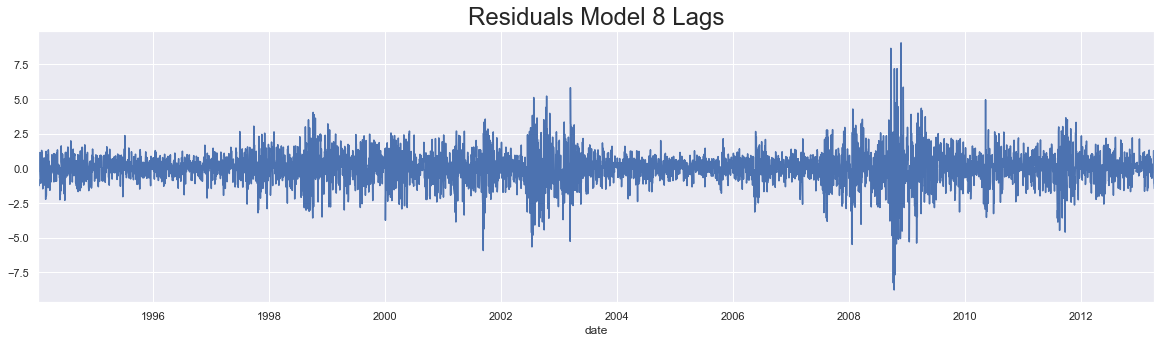

In [25]:
df.res_ret_ma_8[1:].plot(figsize = (20,5))
plt.title("Residuals Model 8 Lags", size = 24)
plt.show()

In [26]:
sts.adfuller(df.res_ret_ma_8[2:])

(-70.83581021411266,
 0.0,
 0,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 15684.052185516364)

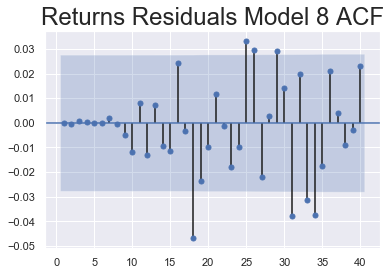

In [27]:
sgt.plot_acf(df.res_ret_ma_8[2:], lags = 40, zero = False)
plt.title("Returns Residuals Model 8 ACF", size = 24)
plt.show()

## Normalizing Returns in df

In [28]:
benchmark = df.returns[1]
df['norm_ret'] = df.returns.div(benchmark).mul(100)
sts.adfuller(df.norm_ret[1:])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-12.770265719497225,
 7.798058336038833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

In [29]:
df

,market_value,returns,res_ret_ma_8,norm_ret
date,,,,
1994-01-07,3445.98,NaN,NaN,NaN
1994-01-10,3440.58,-0.156704,NaN,100.000000
1994-01-11,3413.77,-0.779229,-0.802111,497.260711
1994-01-12,3372.02,-1.222988,-1.269464,780.443046
1994-01-13,3360.01,-0.356166,-0.464780,227.285567
...,...,...,...,...
2013-04-01,6411.74,0.000000,-0.028593,-0.000000
2013-04-02,6490.66,1.230867,1.269089,-785.471020
2013-04-03,6420.28,-1.084327,-1.088285,691.957459
